In [61]:
%load_ext autoreload
%autoreload 2
from dark_matters.input import readInputFile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next I will read in the halo data for the Coma cluster

In [62]:
dataSets = readInputFile("coma.yaml")
print(dataSets)

{'haloData': {'haloName': 'coma', 'haloProfile': 'nfw', 'haloScale': 0.333, 'haloZ': 0.0231, 'haloNorm': 1860000000000000.2}, 'magData': {'magProfile': 'beta', 'magNorm': 4.7, 'magIndex': -0.1635, 'magScale': 0.253, 'magFuncLock': False}, 'gasData': {'gasProfile': 'beta', 'gasNorm': 0.00349, 'gasScale': 0.253, 'gasIndex': -0.327}, 'diffData': {'lossOnly': False, 'coherenceScale': 0.002, 'diffIndex': 1.66666666}, 'partData': {}, 'calcData': {}, 'cosmoData': {}}


The dictionary above contains entries for the Coma environment, namely: haloData, magData, and gasData
These describe the halo, magnetic field, and gas distribution respectively. The other dictionaries are empty. I will read them in from a separate file. First I will assign some variables to the dictionaries

In [63]:
haloData = dataSets['haloData']
gasData = dataSets['gasData']
magData = dataSets['magData']
diffData = dataSets['diffData']

dataSets2 = readInputFile("calculation.yaml")
print(dataSets2)

{'haloData': {}, 'magData': {}, 'gasData': {}, 'diffData': {}, 'partData': {'partModel': 'bb', 'emModel': 'annihilation'}, 'calcData': {'calcMode': 'sb', 'freqMode': 'radio', 'mWIMP': array([100.]), 'fSampleLimits': array([1.e+01, 1.e+05]), 'fSampleNum': 40, 'fSampleSpacing': 'log', 'log10RSampleMinFactor': -3, 'log10ESampleMinFactor': -3, 'calcRmax': 1.0, 'rSampleNum': 61, 'rOutputSpacing': 'log', 'eSampleNum': 71, 'rGreenSampleNum': 121, 'electronExecFile': 'dark_matters/emissions/electron.x', 'electronMode': 'crank-python', 'results': {'electronData': [], 'radioEmData': [], 'primaryEmData': [], 'secondaryEmData': [], 'finalData': [], 'neutrinoEmData': []}}, 'cosmoData': {}}


This file contains only partData and calcData (cosmoData can always be left empty and Planck 2019 results will be used). This is a neat way to keep halo environments separate from the operations you want to perform on them. I will assign the remaining dictionaries below

In [64]:
calcData = dataSets2['calcData']
partData = dataSets2['partData']
cosmoData = dataSets2['cosmoData']

All I need to do is call the runCalculation routine, note that it takes in all the dictionaries and returns them all

In [65]:
from dark_matters.control import runCalculation

calcData,haloData,partData,magData,gasData,diffData,cosmoData = runCalculation(calcData,haloData,partData,magData,gasData,diffData,cosmoData,overWrite=True)

Beginning DarkMatters calculations
Frequency mode: radio
Calculation type: sb
Run Parameters
Frequency Samples: 40
Minimum Frequency Sampled: 1.0e+01 MHz
Maximum Frequency Sampled: 1.0e+05 MHz
Radial Grid Intervals: 61
Green's Function Grid Intervals: 121
Minimum Sampled Radius: 3.33e-04 Mpc
Maximum Sampled Radius: 5.43e+00 Mpc
Halo Parameters: 
Halo Name: coma
Redshift z: 2.31e-02
Luminosity Distance: 104.03 Mpc
Halo profile: nfw
Virial Mass: 1.14e+15 Solar Masses
Virial Radius: 2.72e+00 Mpc
Halo scale radius: 3.33e-01 Mpc
Rho_s/Rho_crit: 1.43e+04
Virial Concentration: 8.2
Gas Parameters: 
Gas density profile: beta
gasScale: 0.253 Mpc
gasIndex: -0.327
gasNorm: 0.00349 cm^-3
Magnetic Field Parameters: 
Magnetic field profile: beta
magNorm: 4.7 micro-Gauss
magScale: 0.253 Mpc
magIndex: -0.1635
Spatial Diffusion
Turbulence scale: 2.00e+00 kpc
Turbulence index: 1.67
Diffusion constant: 3.00e+28 cm^2 s^-1
Dark Matter Parameters: 
WIMP mass: 100.0 GeV
Dark matter particle physics: bb
Emissi

Now I can store the output, I will do so using the yaml format. If I do not specify an 'fName' argument, the code assigns a name automatically

In [66]:
from dark_matters.output import makeOutput

makeOutput(calcData,haloData,partData,magData,gasData,diffData,cosmoData,outMode="yaml")

Now I will plot some of the output. Here I will choose one frequency and plot the surface brightness vs angular radius. For surface brightness, calcData['results']['finalData'] has one array per entry in calcData['mWIMP'], each array is calcData['fSampleNum'] by calcData['rSampleNum']. I can see the values using calcData['fSampleValues'] and calcData['angSampleValues'] for angular radii (when finding surface brightness only).

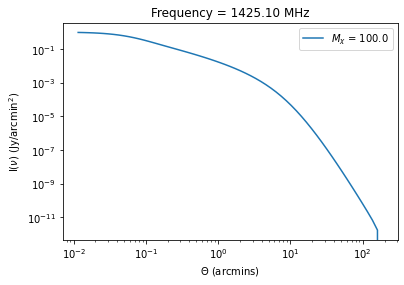

In [67]:
from matplotlib import pyplot as plt

sigV = 1.0
freqIndex = 21

for i in range(len(calcData['mWIMP'])):
    plt.plot(calcData['angSampleValues'],calcData['results']['finalData'][i][freqIndex]*sigV,label=r"$M_\chi$ = "+str(calcData['mWIMP'][i]))
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"I$(\nu)$ (Jy/arcmin$^2$)")
plt.xlabel(r"$\Theta$ (arcmins)")
plt.title("Frequency = {:.2f} MHz".format(calcData['fSampleValues'][freqIndex]))
plt.legend()
plt.show()

Finally, I can produce a fits map for use if I need to compare to observations (by default the cross-section used here is $10^{-26}$ cm $^3$ s $^{-1}$ but the sigV argument can control this). Note I need to specify the location of the target centre in the form of an astropy SkyCoord object to do this. I have it calculated for 3 frequencies, 900 MHz, 1 GHz, and 1.1 GHz. By specifying display_slice = 0 I get the 900 MHz plot appearing. All the data is written to a fits file

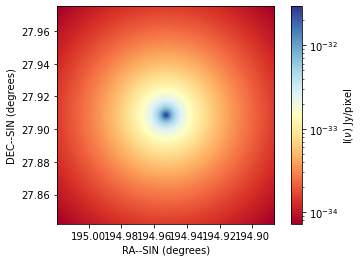

In [68]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from dark_matters.output import fitsMap

c = SkyCoord(ra="12h59m48.7s", dec=+27.9086, frame='icrs',unit=(u.hourangle, u.deg))
fitsMap(c,[0.9e3,1.0e3,1.1e3],calcData,haloData,partData,display_slice=0,sigV=1e-26) 